In [1]:
import tensorflow as tf
from model.generator import read_fasta_as_one_hot_encoded
import numpy as np
import matplotlib.pyplot as plt
from dca.dca_class import dca,return_Hamiltonian,create_numerical_MSA
import pandas as pd 
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from os.path import isfile
import networkx as nx
from Bio import SeqIO
from Bio.SeqRecord  import SeqRecord
from Bio.Seq import Seq
from scipy.stats import pearsonr
from hamiltonian_map import Generative_Functions
from mpl_toolkits.axes_grid1 import make_axes_locatable
from cycler import cycler
from Bio import AlignIO
from numba import njit,prange
import pickle
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve
##################
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 10),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large' }

plt.rcParams.update(params)

plt.rc('axes', prop_cycle = cycler('color', ['#377eb8', '#ff7f00', '#4daf4a',
                  '#e41a1c', '#984ea3', '#f781bf', '#a65628', 
                  '#999999', '#dede00']))
cm = ['#377eb8', '#ff7f00', '#4daf4a', '#e41a1c', '#984ea3',
                  '#f781bf', '#a65628', 
                  '#999999', '#dede00']

2025-06-30 14:54:10.791987: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### **Fasta of Latent Space** ###

In [14]:
output_path = 'trpm/all_grid.fasta' # grid output
full_alignment = "trpm/zed.fasta" # Family MSA
pixels = 500 # N^2 grid of sequences will be produced
def get_grid_hamiltonian(mfdcamodel,all_grid_path):
    hamil_mat,coords=mfdcamodel.compute_Hamiltonian(all_grid_path)
    print(coords[0],coords[-1])
    return hamil_mat.reshape((500,500)),float(coords[0]),float(coords[-1])
mfdcamodel = dca(full_alignment)
mfdcamodel.mean_field()
hamiltonian_3di=mfdcamodel.compute_Hamiltonian(full_alignment)
hamil_mat,ax_min,ax_max=get_grid_hamiltonian(mfdcamodel=mfdcamodel,all_grid_path=output_path)


-6.0 6.0


### **Visualize Input Training Data** ###

In [28]:
zed_train =np.array([[float(str(i.description).split(" ")[0]),float(str(i.description).split(" ")[1])] for i in SeqIO.parse("/lustre/hdd/LAS/potoyan-lab/Divyanshu/git-repos/3Di_Landscape/trpm/zed.fasta","fasta")])

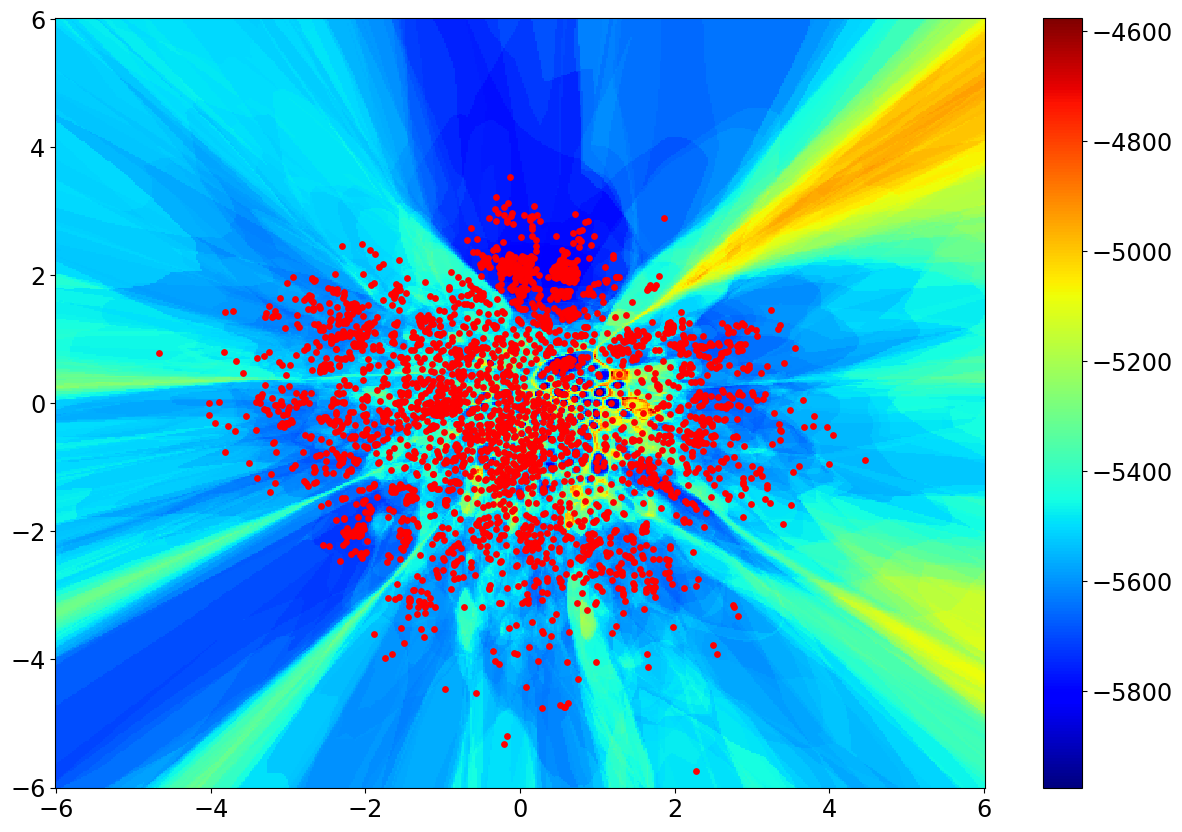

In [29]:

resolution = [ax_min, ax_max, pixels]
a, b = np.meshgrid(np.linspace(resolution[0], resolution[1], resolution[2]),
                       np.linspace(resolution[0], resolution[1], resolution[2]))
fig, ax = plt.subplots()
c = ax.pcolormesh(b, a, hamil_mat, cmap='jet')
fig.colorbar(c, ax=ax)
plt.scatter(zed_train[:,0],zed_train[:,1],s=15,c='red')
plt.show()

### **DCA Analysis of Input Fasta** ###
#### DI(Direct Information) Contacts Calulated by DCA ####

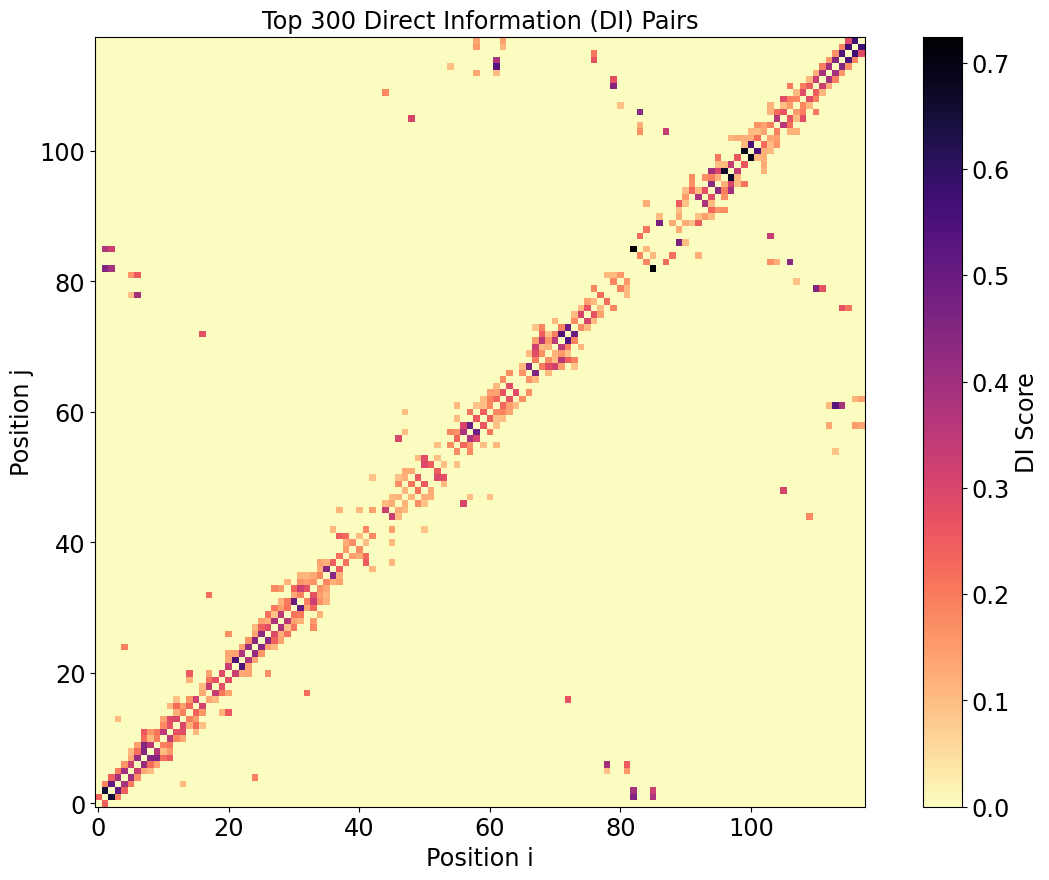

In [109]:

mfdcamodel = dca("globin/new_generated.fasta")
mfdcamodel.mean_field()
hamiltonian_3di=mfdcamodel.compute_Hamiltonian("globin/new_generated.fasta")
direct = np.zeros((mfdcamodel.N, mfdcamodel.N))

# Extract all DI values with their indices
di_list = []
count = 0
for i in range(mfdcamodel.N):
    for j in range(i + 1, mfdcamodel.N):
        di_score = mfdcamodel.DI[count][2]
        di_list.append((i, j, di_score))
        count += 1

# Sort by DI score descending and select top N
N = 300  # change to desired number of top pairs
top_di = sorted(di_list, key=lambda x: x[2], reverse=True)[:N]

# Fill upper triangle with top N DI scores
for i, j, score in top_di:
    direct[i, j] = score
    direct[j, i] = score

# Plot the upper triangle matrix

plt.imshow(direct, cmap='magma_r')
plt.title(f"Top {N} Direct Information (DI) Pairs")
plt.colorbar(label='DI Score')
plt.xlabel("Position i")
plt.ylabel("Position j")
plt.gca().invert_yaxis() 
plt.show()


#### Correlation Between Generated and Training DCA Score ####

In [22]:
mat,ax_min,ax_max=get_grid_hamiltonian(mfdcamodel=mfdcamodel,all_grid_path="globin/all_grid.fasta")
zed=np.array([[float(str(i.description).split(" ")[0]),float(str(i.description).split(" ")[1])] for i in SeqIO.parse("globin/zed.fasta","fasta")])
thresholds=[0.0]
numseq_r=[]
for threshold in thresholds:
    generate_hamil=[]
    relevant_hamil=[]
    for j,i in enumerate(zed):
        if ((i[0]>threshold or i[0]<-threshold) and (i[1]>threshold or i[1]<-threshold)):
            generate_hamil.append(mat[int((i[0]-ax_min)*500/(2*ax_max)),int((i[1]-ax_min)*500/(2*ax_max))])
            relevant_hamil.append(hamiltonian_3di[0][j])
    if (len(generate_hamil)>200):
        r_value, p_value = pearsonr(generate_hamil,relevant_hamil)
        numseq_r.append([r_value,len(generate_hamil)])
    else:
        break
generate_hamil=np.array(generate_hamil)
relevant_hamil=np.array(relevant_hamil)
numseq_r=np.asarray(numseq_r)

-6.0 6.0


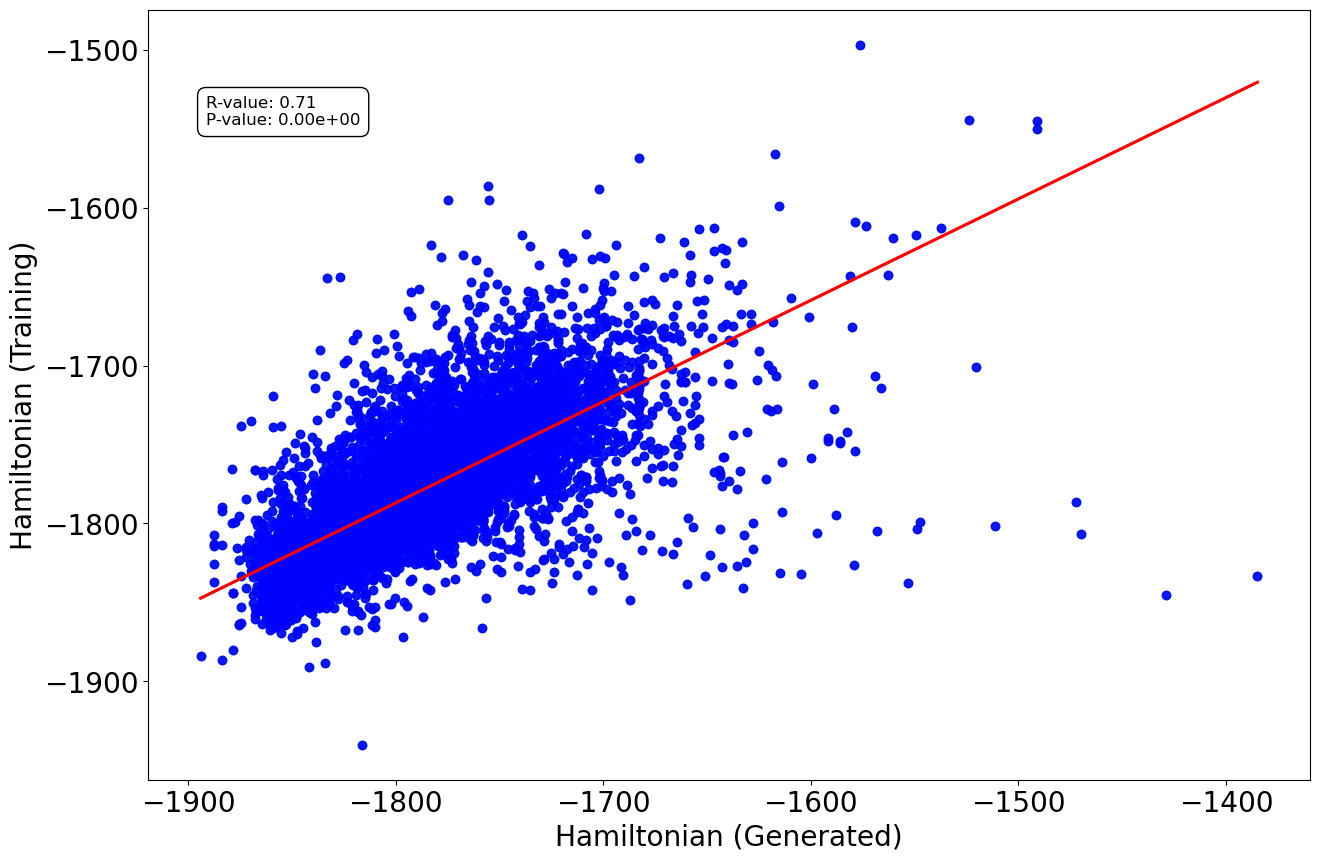

In [23]:
plt.scatter(generate_hamil,relevant_hamil)
sns.regplot(x=generate_hamil, y=relevant_hamil, scatter=True, ci=None, line_kws={"color": "red"},color='blue')
plt.text(0.05, 0.85, f'R-value: {r_value:.2f}\nP-value: {p_value:.2e}', transform=plt.gca().transAxes, fontsize=12, color='black', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
# plt.text(0.02, 0.85, f'P-value: {p_value:.2e}', transform=plt.gca().transAxes, fontsize=12, color='black')
plt.xlabel("Hamiltonian (Generated)")
plt.ylabel("Hamiltonian (Training)")
plt.show()

### Function Based Clustering ###

In [24]:
index={"cytoglobin":[],"myoglobin":[],"flavohemoglobin":[],"neuroglobin":[],"leghemoglobin":[],"cryobacterium":[],"hemo_alpha":[],"hemo_beta":[]}
index_id={}
c=0
for i in list(SeqIO.parse("globin/new_generated.fasta", "fasta")):
    if "cytoglobin" in i.description.lower():
        index["cytoglobin"].append([zed[int(c)][0],zed[int(c)][1]])
        index_id.update({f"{zed[int(c)][0]},{zed[int(c)][1]}":i.id})
    elif "myoglobin" in i.description.lower():
        index["myoglobin"].append([zed[int(c)][0],zed[int(c)][1]])
        index_id.update({f"{zed[int(c)][0]},{zed[int(c)][1]}":i.id})
    elif "flavo" in i.description.lower() :
    # and ("F4FH74" in i or "A0A0N0LWZ5" in i or "A0A1D8T7A6" in i or "T0GA81" in i or "A0A1H7CNG1" in i or
    #                                     "A0A0X8GLM9" in i or "A0A5C4WKN4" in i or "A0A543FJ13" in i or "A0A4V3CQR8" in i or
    #                                     "A0A1H0XPG8" in i or "A0A1D8UY24" in i):
        index["flavohemoglobin"].append([zed[int(c)][0],zed[int(c)][1]])
        index_id.update({f"{zed[int(c)][0]},{zed[int(c)][1]}":i.id})
    elif "neuroglobin" in i.description.lower():
        index["neuroglobin"].append([zed[int(c)][0],zed[int(c)][1]])
        index_id.update({f"{zed[int(c)][0]},{zed[int(c)][1]}":i.id})
    elif "leghemoglobin" in i.description.lower():
        index["leghemoglobin"].append([zed[int(c)][0],zed[int(c)][1]])
        index_id.update({f"{zed[int(c)][0]},{zed[int(c)][1]}":i.id})
    elif ("bacteri" in i.description.lower() and " hemoglobin" in i.description.lower()):
    # or "q0p842" in i.lower() or "i1sba3"in i.lower():
        index["cryobacterium"].append([zed[int(c)][0],zed[int(c)][1]])
        index_id.update({f"{zed[int(c)][0]},{zed[int(c)][1]}":i.id})
    elif "subunit alpha" in i.description.lower():
    # and ("bos taurus" in i.lower() or"felis catus" in i.lower() or "homo sapiens" in i.lower() or "capra hircus" in i.lower() or "equus caballus" in i.lower() or
    #                                     "canis lupus familiaris" in i.lower() or "camelus dromedarius" in i.lower() or "cavia porcellus" in i.lower() or "odocoileus virginianus" in i.lower() or
    #                                     "oryctolagus cuniculus" in i.lower() or "ovis aries" in i.lower() or "rattus norvegicus" in i.lower() or "sus scrofa" in i.lower()):
        index["hemo_alpha"].append(zed[int(c)])
        index_id.update({f"{zed[int(c)][0]},{zed[int(c)][1]}":i.id})
    elif "subunit beta" in i.description.lower():
    # and ("bos taurus" in i.lower() or"felis catus" in i.lower() or "homo sapiens" in i.lower() or "capra hircus" in i.lower() or "equus caballus" in i.lower() or
    #                                     "canis lupus familiaris" in i.lower() or "camelus dromedarius" in i.lower() or "cavia porcellus" in i.lower() or "odocoileus virginianus" in i.lower() or
    #                                     "oryctolagus cuniculus" in i.lower() or "ovis aries" in i.lower() or "rattus norvegicus" in i.lower() or "sus scrofa" in i.lower()):
        index["hemo_beta"].append(zed[int(c)])
        index_id.update({f"{zed[int(c)][0]},{zed[int(c)][1]}":i.id})
    c+=1
coord_train=np.asarray([np.asarray(index[i]) for i in index.keys()])

/tmp/ipykernel_3628960/3971226289.py:40: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  coord_train=np.asarray([np.asarray(index[i]) for i in index.keys()])


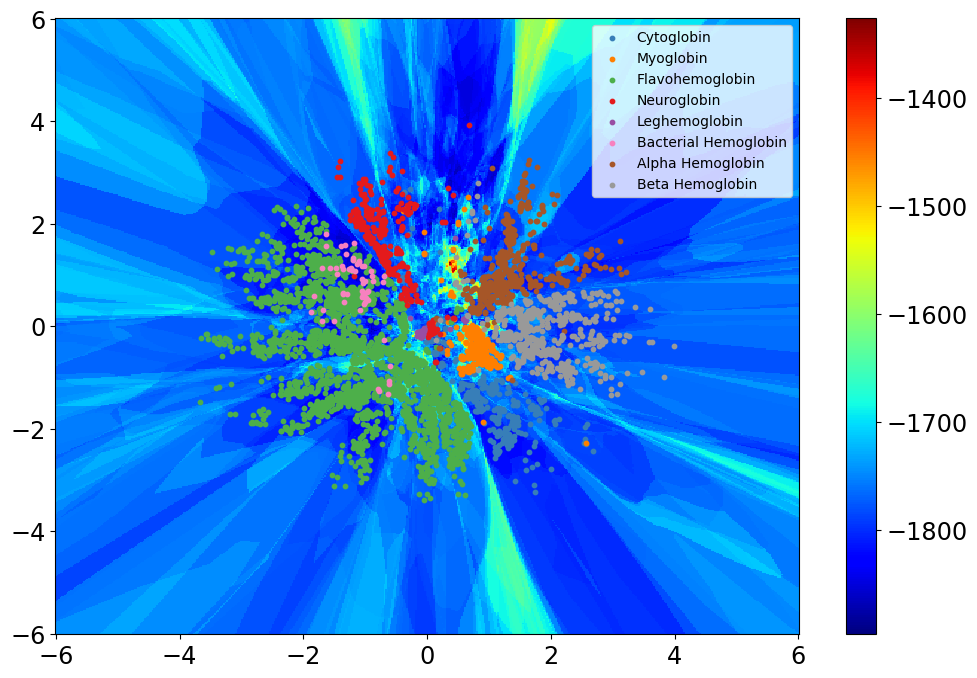

In [ ]:

resolution = [ax_min, ax_max, pixels]
a, b = np.meshgrid(np.linspace(resolution[0], resolution[1], resolution[2]),
                       np.linspace(resolution[0], resolution[1], resolution[2]))
fig, ax = plt.subplots()
c = ax.pcolormesh(b, a, mat, cmap='jet')
fig.colorbar(c, ax=ax)
plt.scatter(x=coord_train[0][:,0],y=coord_train[0][:,1],s=10)
plt.scatter(x=coord_train[1][:,0],y=coord_train[1][:,1],s=10)
plt.scatter(x=coord_train[2][:,0],y=coord_train[2][:,1],s=10)
plt.scatter(x=coord_train[3][:,0],y=coord_train[3][:,1],s=10)
plt.scatter(x=coord_train[4][:,0],y=coord_train[4][:,1],s=10)
plt.scatter(x=coord_train[5][:,0],y=coord_train[5][:,1],s=10)
plt.scatter(x=coord_train[6][:,0],y=coord_train[6][:,1],s=10)
plt.scatter(x=coord_train[7][:,0],y=coord_train[7][:,1],s=10)
plt.legend(["Cytoglobin","Myoglobin","Flavohemoglobin","Neuroglobin","Leghemoglobin","Bacterial Hemoglobin","Alpha Hemoglobin","Beta Hemoglobin"],fontsize=10)
plt.show()

#### Pairwise Sequence Similarity ####

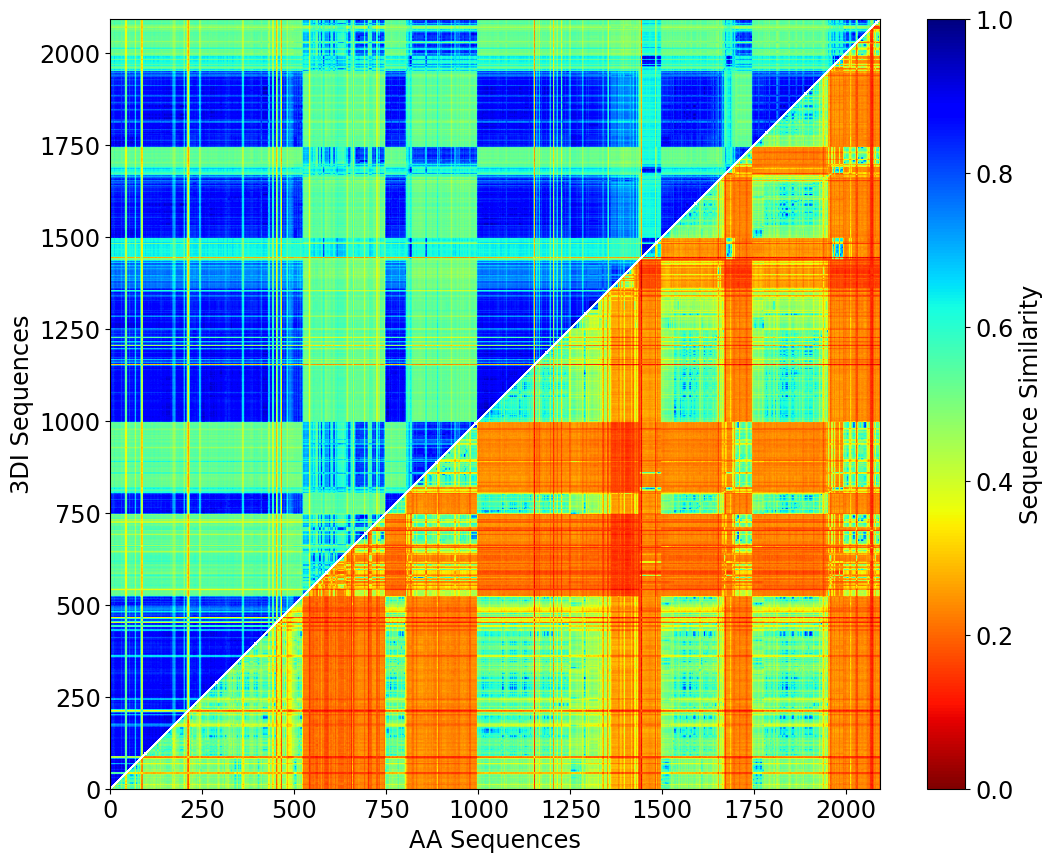

In [108]:
identity_matrix=np.load("/lustre/hdd/LAS/potoyan-lab/Divyanshu/git-repos/3Di_Landscape/cMDH/di_identity_matrix.npy")
identity_matrix_seq=np.load("/lustre/hdd/LAS/potoyan-lab/Divyanshu/git-repos/3Di_Landscape/cMDH/aa_identity_matrix.npy")

fig, ax = plt.subplots()

# Prepare upper and lower triangles
upper = np.triu(identity_matrix, k=1)
lower = np.tril(identity_matrix_seq, k=-1)

# Mask zeros for better visualization
masked_upper = np.ma.masked_where(upper == 0, upper)
masked_lower = np.ma.masked_where(lower == 0, lower)

# Plot upper triangle
cmap = plt.get_cmap('jet_r')
im1 = ax.imshow(masked_upper, cmap=cmap, vmin=0, vmax=1)

# Plot lower triangle
im2 = ax.imshow(masked_lower, cmap=cmap, vmin=0, vmax=1)

# Add colorbar
cbar = plt.colorbar(im1, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label("Sequence Similarity")

ax.set_xlabel("AA Sequences")
ax.set_ylabel("3DI Sequences")
ax.invert_yaxis()
plt.show()

#### Coupling Strength ####

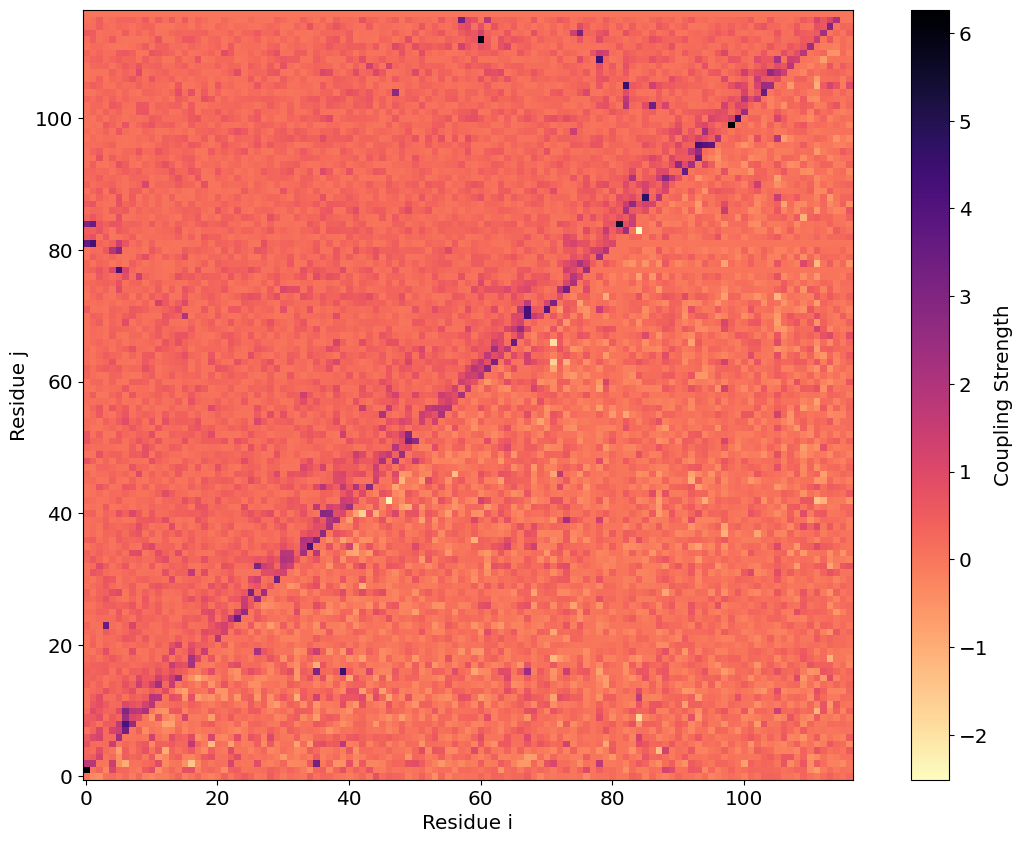

In [2]:
coupling_array_3dis=np.load("/lustre/hdd/LAS/potoyan-lab/Divyanshu/git-repos/3Di_Landscape/globin/coupling_array_3di.npy")
coupling_array_seqs=np.load("/lustre/hdd/LAS/potoyan-lab/Divyanshu/git-repos/3Di_Landscape/globin/coupling_array_seq.npy")
assert coupling_array_3dis.shape == coupling_array_seqs.shape, "Shape mismatch between 3DI and sequence coupling arrays"
direct=np.empty(coupling_array_3dis.shape)
for i in range(coupling_array_3dis.shape[0]):
    for j in range(coupling_array_3dis.shape[1]):
        direct[i, j] = coupling_array_3dis[i, j]
        direct[j, i] = coupling_array_seqs[j, i]

plt.imshow(direct, cmap='magma_r')
plt.colorbar(label='Coupling Strength')
plt.xlabel("Residue i")
plt.ylabel("Residue j")
plt.gca().invert_yaxis() 
plt.show()


#### Performance Evaluation ####

In [9]:
metrics_3di_trpm = []
metrics_seq_trpm = []
metrics_3di_globin = []
metrics_seq_globin = []
metrics_3di_mdh = []
metrics_seq_mdh = []

def evaluate_contact_map(coupling_array, contact_map, threshold):
    assert coupling_array.shape == contact_map.shape

    binary_prediction = (coupling_array >= threshold).astype(int)

    tp = np.sum((binary_prediction == 1) & (contact_map == 1))
    fp = np.sum((binary_prediction == 1) & (contact_map == 0))
    tn = np.sum((binary_prediction == 0) & (contact_map == 0))
    fn = np.sum((binary_prediction == 0) & (contact_map == 1))

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) else 0
    recall = tp / (tp + fn) if (tp + fn) else 0
    specificity = tn / (tn + fp) if (tn + fp) else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) else 0
    fpr = fp / (fp + tn) if (fp + tn) else 0
    tpr = recall  # same as recall

    # Flatten arrays for AUC calculation
    try:
        roc_auc = roc_auc_score(contact_map.flatten(), coupling_array.flatten())
    except ValueError:
        roc_auc = np.nan  # In case there's only one class in contact_map

    try:
        pr_auc = average_precision_score(contact_map.flatten(), coupling_array.flatten())
    except ValueError:
        pr_auc = np.nan

    return [accuracy, precision, recall, f1_score, roc_auc, pr_auc]


# Assuming these are lists of arrays:
# coupling_array_3dis, coupling_array_seqs, contact_map

threshold_3di = 1  # choose a fixed threshold (or compute it based on data)
threshold_seq = 1  # same here or choose independently


with open("trpm/coupling_array_seqs.pkl", "rb") as f:
    coupling_array_seqs_trpm = pickle.load(f)
with open("trpm/coupling_array_3dis.pkl", "rb") as f:
    coupling_array_3dis_trpm = pickle.load(f)
with open("trpm/alphafold_contact_map.pkl", "rb") as f:
    contact_map_trpm = pickle.load(f)
with open("globin/coupling_array_seqs.pkl", "rb") as f:
    coupling_array_seqs_globin = pickle.load(f)
with open("globin/coupling_array_3dis.pkl", "rb") as f:
    coupling_array_3dis_globin = pickle.load(f)
with open("globin/alphafold_contact_map.pkl", "rb") as f:
    contact_map_globin = pickle.load(f)
with open("cMDH/coupling_array_seqs.pkl", "rb") as f:
    coupling_array_seqs_mdh = pickle.load(f)
with open("cMDH/coupling_array_3dis.pkl", "rb") as f:
    coupling_array_3dis_mdh = pickle.load(f)
with open("cMDH/alphafold_contact_map.pkl", "rb") as f:
    contact_map_mdh = pickle.load(f)
for i in range(len(coupling_array_seqs_trpm)):
    if coupling_array_3dis_trpm[i].shape != contact_map_trpm[i].shape or coupling_array_seqs_trpm[i].shape != contact_map_trpm[i].shape:
        continue
    result_3di = evaluate_contact_map(coupling_array_3dis_trpm[i], contact_map_trpm[i], threshold_3di)
    result_seq = evaluate_contact_map(coupling_array_seqs_trpm[i], contact_map_trpm[i], threshold_seq)
    metrics_3di_trpm.append(result_3di)
    metrics_seq_trpm.append(result_seq)
for i in range(len(coupling_array_seqs_globin)):
    if coupling_array_3dis_globin[i].shape != contact_map_globin[i].shape or coupling_array_seqs_globin[i].shape != contact_map_globin[i].shape:
        continue
    result_3di = evaluate_contact_map(coupling_array_3dis_globin[i], contact_map_globin[i], threshold_3di)
    result_seq = evaluate_contact_map(coupling_array_seqs_globin[i], contact_map_globin[i], threshold_seq)
    metrics_3di_globin.append(result_3di)
    metrics_seq_globin.append(result_seq)
for i in range(len(coupling_array_seqs_mdh)):
    if coupling_array_3dis_mdh[i].shape != contact_map_mdh[i].shape or coupling_array_seqs_mdh[i].shape != contact_map_mdh[i].shape:
        continue
    result_3di = evaluate_contact_map(coupling_array_3dis_mdh[i], contact_map_mdh[i], threshold_3di)
    result_seq = evaluate_contact_map(coupling_array_seqs_mdh[i], contact_map_mdh[i], threshold_seq)
    metrics_3di_mdh.append(result_3di)
    metrics_seq_mdh.append(result_seq)

# Convert to arrays for easier averaging
metrics_3di_trpm = np.array(metrics_3di_trpm)
metrics_seq_trpm = np.array(metrics_seq_trpm)
metrics_3di_globin = np.array(metrics_3di_globin)
metrics_seq_globin = np.array(metrics_seq_globin)
metrics_3di_mdh = np.array(metrics_3di_mdh)
metrics_seq_mdh = np.array(metrics_seq_mdh)



/lustre/hdd/LAS/potoyan-lab/Divyanshu/git-repos/3Di_Landscape


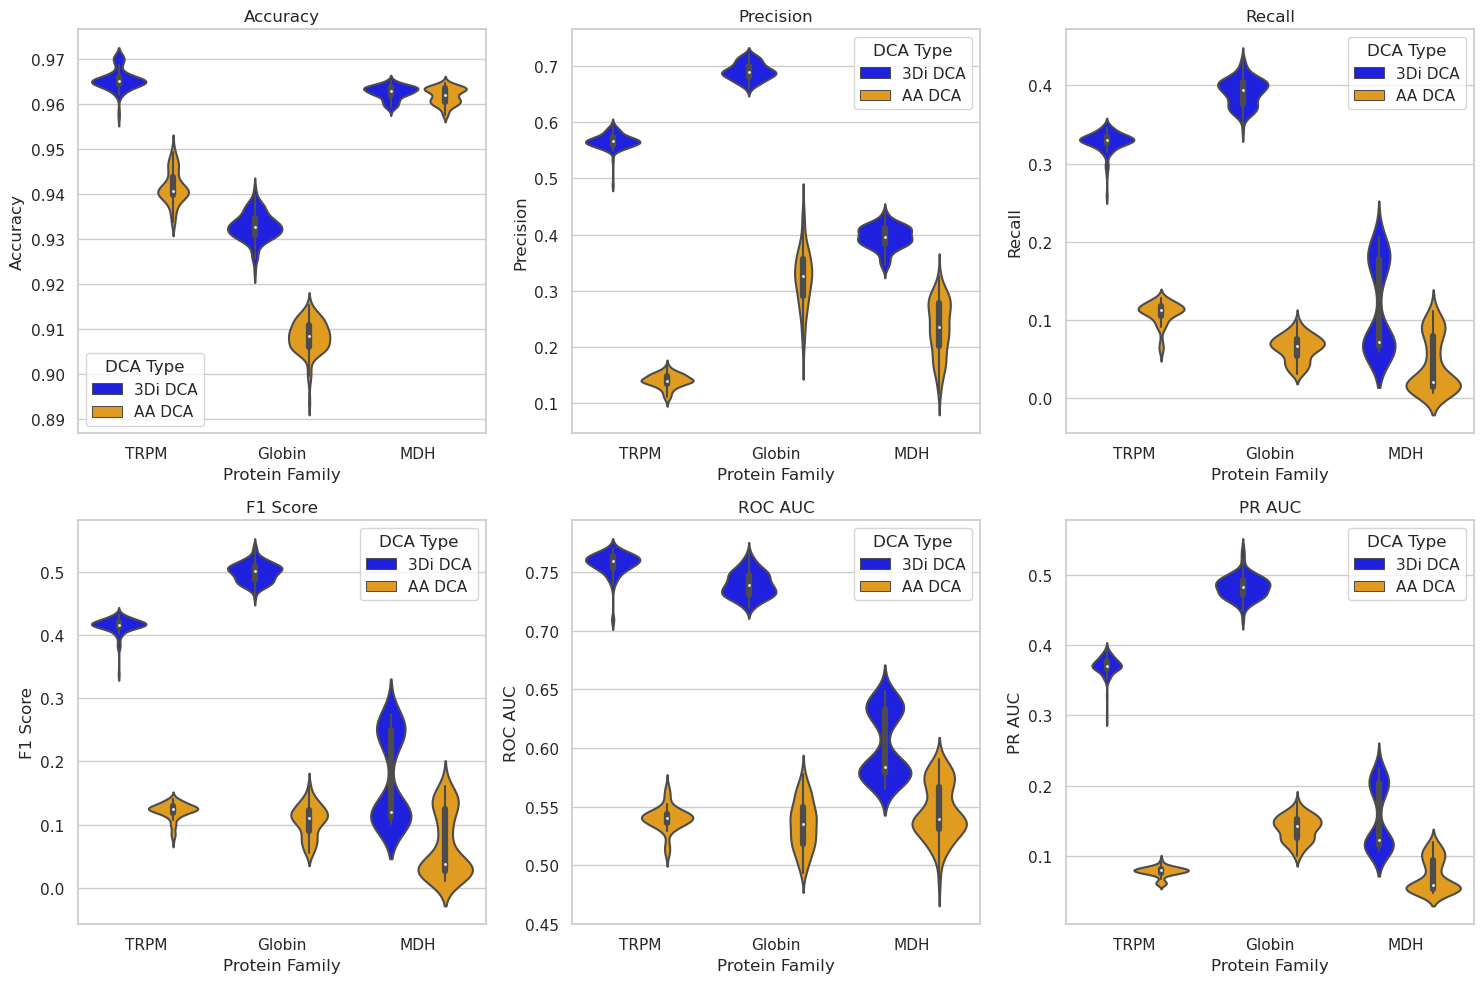

In [ ]:
metric_names = ["Accuracy", "Precision", "Recall", "F1 Score", "ROC AUC", "PR AUC"]

# Helper function to convert each metrics array into tidy DataFrame
def to_df(metrics_array, protein_name, dca_type):
    df = pd.DataFrame(metrics_array, columns=metric_names)
    df["Protein"] = protein_name
    df["Type"] = dca_type
    return df

#Combine all data
df_all = pd.concat([
    to_df(metrics_3di_trpm, "TRPM", "3Di DCA"),
    to_df(metrics_seq_trpm, "TRPM", "AA DCA"),
    to_df(metrics_3di_globin, "Globin", "3Di DCA"),
    to_df(metrics_seq_globin, "Globin", "AA DCA"),
    to_df(metrics_3di_mdh, "MDH", "3Di DCA"),
    to_df(metrics_seq_mdh, "MDH", "AA DCA"),
], ignore_index=True)

#Melt to long-form for Seaborn
df_melted = pd.melt(df_all, id_vars=["Protein", "Type"], var_name="Metric", value_name="Score")

sns.set(style="whitegrid")

#Create 2x3 grid for 6 metrics
fig, axes = plt.subplots(2, 3)
axes = axes.flatten()

# Plot each metric in its own subplot
for i, metric in enumerate(metric_names):
    ax = axes[i]
    data = df_melted[df_melted["Metric"] == metric]

    sns.violinplot(
        data=data,
        x="Protein",        # Each protein family
        y="Score",
        hue="Type",         # DCA type: 3Di vs AA
        palette={"3Di DCA": "blue", "AA DCA": "orange"},
        ax=ax,
        inner="box",
        dodge=True          # Side-by-side violins
    )

    ax.set_title(metric)
    ax.set_ylabel(metric)
    ax.set_xlabel("Protein Family")
    ax.tick_params(axis='x', rotation=0)

    ax.legend(title="DCA Type")

plt.tight_layout()
plt.show()